In [1]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import mra 
import selector as se

In [2]:
plt.rcParams['text.usetex'] = True
np.random.seed(123)

# Create parameters

In [3]:
rho = 1.
num_points = 10
eps_sublevel = percent = 0.1

m = num_agents = 100
n = 25

filename = "subgrad_ot_N%d_%.2f_n%d"%(num_points, eps_sublevel, num_agents)

In [4]:
C, a, A_eq, b_eq, A_ineq, b_ineq, volumes, mean = mra.ot_data(m, n)

In [5]:
b_norm = (np.linalg.norm(b_eq)**2 + np.linalg.norm(b_ineq)**2)**0.5
C.shape

(100, 25)

# CVXPY centralized solution

In [6]:
true_x, true_f, true_lamb = mra.centralized_solution_ot(C, a, A_eq, b_eq, A_ineq, b_ineq)
print(f"{true_f=}")

true_f=1.1519520887311967


In [7]:
(true_lamb.max() - true_lamb.min()) / true_lamb.max()

1.5730112050161082

In [8]:
true_x.shape, true_lamb.shape

((2500, 1), (50, 1))

In [9]:
fun_agents_eps = []
fun_agents_noisy_y = []

for i in range(num_agents):
    fun_agents_eps += [lambda lamb_k, K, i=i: mra.ot_query_multiple_actions(lamb_k, C[i:i+1].T, a[i, 0], vol_i=volumes[i, 0], 
                                                                       eps_sublevel=eps_sublevel, num_points=K)]
    fun_agents_noisy_y += [lambda lamb_k, K, i=i: mra.ot_query_multiple_actions_noisy_prices(lamb_k, C[i:i+1].T, a[i, 0], vol_i=volumes[i, 0], 
                                                                       percent=percent, num_points=K)]


fun_obj_val = lambda x_k: mra.ot_obj_value(x_k, C, a, b_eq)

# Dual subgradient

In [10]:
price_min, price_max = mra.ot_prime_initial_bound(true_lamb, A_eq, b_eq, A_ineq, b_ineq)

K_i = num_points
N = num_agents
primal_var_size = A_eq.shape[1]

### Best learning schedule

In [ ]:
alpha_ks = ["0.1/sqrt(k)", "1/sqrt(k)", "1/k", "10/k"]
func_alphas = {"0.1/sqrt(k)": lambda k: 0.1 / np.sqrt(k+1), 
               "1/sqrt(k)": lambda k: 1 / np.sqrt(k+1),
               "1/k": lambda k: 1 / (k+1),
               "10/k": lambda k: 10 / (k+1)}

best_schedule = [np.inf, "0.1/sqrt(k)"] 

for alpha_k, func_alpha_k in func_alphas.items():
    print(f"{alpha_k=}")
    all_results = mra.dual_proj_subgradient(fun_agents_eps, fun_obj_val, primal_var_size,
                                                             func_alpha_k, A_ineq=A_ineq, b_ineq=b_ineq, A_eq=A_eq, b_eq=b_eq,
                                                            price_max=price_max, price_min=price_min, relaxed=True, 
                                                            postprocessing=1, K_i=1, num_iters=20, 
                                                            true_f=true_f, print_freq=50, eps_lamb=1e-28,
                                                            res_type="primal_compl_slack", history=1)[0]

    if all_results["viol_primal_paver_xk"][-1] < best_schedule[0]:
        best_schedule = [all_results["viol_primal_paver_xk"][-1], alpha_k]

alpha_k='0.1/sqrt(k)'
epoch=0, f_subopt_xk=3.0519E-01,  f_subopt_mra=3.0519E-01,  viol_xk=3.9564E+00, viol_mra=3.9564E+00, lamb_rel_diff=INF


/Users/tepars/Documents/postdoc/mra_precovery/mra/subgrad.py:65: RuntimeWarning: divide by zero encountered in scalar divide
  lamb_rel_diff = np.linalg.norm(lamb_k - lamb_prev) / np.linalg.norm(lamb_prev)


epoch=19, f_subopt_xk=2.3940E-01,  f_subopt_mra=2.3940E-01,  viol_xk=2.1855E+00, viol_mra=2.1855E+00, lamb_rel_diff=9.2789E-04
alpha_k='1/sqrt(k)'
epoch=0, f_subopt_xk=3.0519E-01,  f_subopt_mra=3.0519E-01,  viol_xk=3.9564E+00, viol_mra=3.9564E+00, lamb_rel_diff=INF
epoch=19, f_subopt_xk=7.9396E-02,  f_subopt_mra=7.9396E-02,  viol_xk=1.3016E+00, viol_mra=1.3016E+00, lamb_rel_diff=4.8632E-03
alpha_k='1/k'
epoch=0, f_subopt_xk=3.0519E-01,  f_subopt_mra=3.0519E-01,  viol_xk=3.9564E+00, viol_mra=3.9564E+00, lamb_rel_diff=INF
epoch=19, f_subopt_xk=1.4238E-01,  f_subopt_mra=1.4238E-01,  viol_xk=1.3379E+00, viol_mra=1.3379E+00, lamb_rel_diff=1.2016E-03
alpha_k='10/k'
epoch=0, f_subopt_xk=3.0519E-01,  f_subopt_mra=3.0519E-01,  viol_xk=3.9564E+00, viol_mra=3.9564E+00, lamb_rel_diff=INF
epoch=19, f_subopt_xk=5.5610E-02,  f_subopt_mra=5.5610E-02,  viol_xk=1.4210E+00, viol_mra=1.4210E+00, lamb_rel_diff=1.5251E-02


In [12]:
best_alpha_k = best_schedule[1]
print(f"{best_alpha_k=}")
func_alpha_k = func_alphas[best_alpha_k]

best_alpha_k='10/k'


In [ ]:
all_results_eps, lamb_k_eps, _, x_k, _, mra_xk_eps  = mra.dual_proj_subgradient(fun_agents_eps, fun_obj_val, primal_var_size, func_alpha_k, 
                                                                                             A_ineq=A_ineq, b_ineq=b_ineq, 
                                                            price_max=price_max, price_min=price_min, relaxed=True, 
                                                            postprocessing=1, K_i=K_i, num_iters=100, A_eq=A_eq, b_eq=b_eq,
                                                            true_f=true_f, print_freq=50, eps_lamb=1e-28,
                                                            res_type="primal_compl_slack", history=1)


all_results_noisy_y, lamb_k_eps, _, x_k, _, mra_xk_noisy_y  = mra.dual_proj_subgradient(fun_agents_noisy_y, fun_obj_val, primal_var_size, func_alpha_k, 
                                                                                             A_ineq=A_ineq, b_ineq=b_ineq, 
                                                            price_max=price_max, price_min=price_min, relaxed=True, 
                                                            postprocessing=1, K_i=K_i, num_iters=100, A_eq=A_eq, b_eq=b_eq,
                                                            true_f=true_f, print_freq=50, eps_lamb=1e-28,
                                                            res_type="primal_compl_slack", history=1)

epoch=0, f_subopt_xk=3.0519E-01,  f_subopt_mra=5.6941E-02,  viol_xk=3.9564E+00, viol_mra=1.0616E+00, lamb_rel_diff=INF
epoch=50, f_subopt_xk=4.7693E-03,  f_subopt_mra=1.5988E-01,  viol_xk=1.4956E+00, viol_mra=9.8216E-02, lamb_rel_diff=6.5920E-03
epoch=99, f_subopt_xk=3.8144E-02,  f_subopt_mra=1.7843E-01,  viol_xk=1.8428E+00, viol_mra=8.9718E-02, lamb_rel_diff=2.0808E-03
epoch=0, f_subopt_xk=3.0519E-01,  f_subopt_mra=2.2310E-01,  viol_xk=3.9564E+00, viol_mra=2.5490E+00, lamb_rel_diff=INF
epoch=50, f_subopt_xk=4.7693E-03,  f_subopt_mra=9.7723E-03,  viol_xk=1.4956E+00, viol_mra=1.1746E-01, lamb_rel_diff=6.5920E-03
epoch=99, f_subopt_xk=3.8144E-02,  f_subopt_mra=1.0269E-02,  viol_xk=1.8428E+00, viol_mra=1.3381E-01, lamb_rel_diff=2.0808E-03


In [9]:
if len(all_results_noisy_y["subopt_xk"]) > len(all_results_eps["subopt_xk"]):
    all_res = all_results_noisy_y
else:
    all_res = all_results_eps

In [13]:
T = 100
idx_xk = np.argmin(np.array(all_res["viol_primal_xk"])[:T])
idx_paverage = np.argmin(np.array(all_res["viol_primal_paver_xk"])[:T])
idx_noisy_y = 25#np.where(np.array(all_results_noisy_y["viol_primal_mra_xk"][:T]) < 1e-8)[0][0]
idx_eps = np.where(np.array(all_results_eps["viol_primal_mra_xk"][:T]) / b_norm < 1e-6)[0][0]

print(f"{idx_xk=}, {idx_eps=}, {idx_noisy_y=}, {idx_paverage=}")

print("xk", (np.abs(np.array(all_res["f_xk"]) - true_f)/np.abs(true_f))[idx_xk],
    "sub_eps", (np.abs(np.array(all_results_eps["f_mra_xk"]) - true_f)/np.abs(true_f))[idx_eps],
    "noisy_y", (np.abs(np.array(all_results_noisy_y["f_mra_xk"]) - true_f)/np.abs(true_f))[idx_noisy_y],
    "proj", ((np.abs(np.array(all_res["f_proj_xk"]) - true_f))/np.abs(true_f)).min(),
    "paverage", (np.abs(np.array(all_res["f_paver_xk"]) - true_f)/np.abs(true_f))[idx_paverage])

print("xk", np.array(all_res["viol_primal_xk"])[idx_xk]/ b_norm,
      "sub_eps", all_results_eps["viol_primal_mra_xk"][idx_eps]/ b_norm,
      "noisy_y", all_results_noisy_y["viol_primal_mra_xk"][idx_noisy_y]/ b_norm,
      "paverage", np.array(all_res["viol_primal_paver_xk"])[idx_paverage]/ b_norm)

idx_xk=88, idx_eps=16, idx_noisy_y=25, idx_paverage=99
xk 0.011268260553223946 sub_eps 0.1549568567825902 noisy_y 0.03379400071037677 proj inf paverage 0.06451871822419084
xk 0.869193884077286 sub_eps 2.218182663564885e-08 noisy_y 0.15138891949686092 paverage 0.2648583943158274


In [23]:
import pickle

with open(f"../results/{filename}_dict.pkl", "wb") as file:
    pickle.dump({"eps":all_results_eps, "noisy_y":all_results_noisy_y}, file)
with open(f"../results/{filename}_dict.pkl", "rb") as file:
    res = pickle.load(file)
# res["eps"].keys()

In [7]:
import pickle

with open(f"../results/{filename}_dict.pkl", "rb") as file:
    res = pickle.load(file)

all_results_eps, all_results_noisy_y = res["eps"], res["noisy_y"]
T = 100

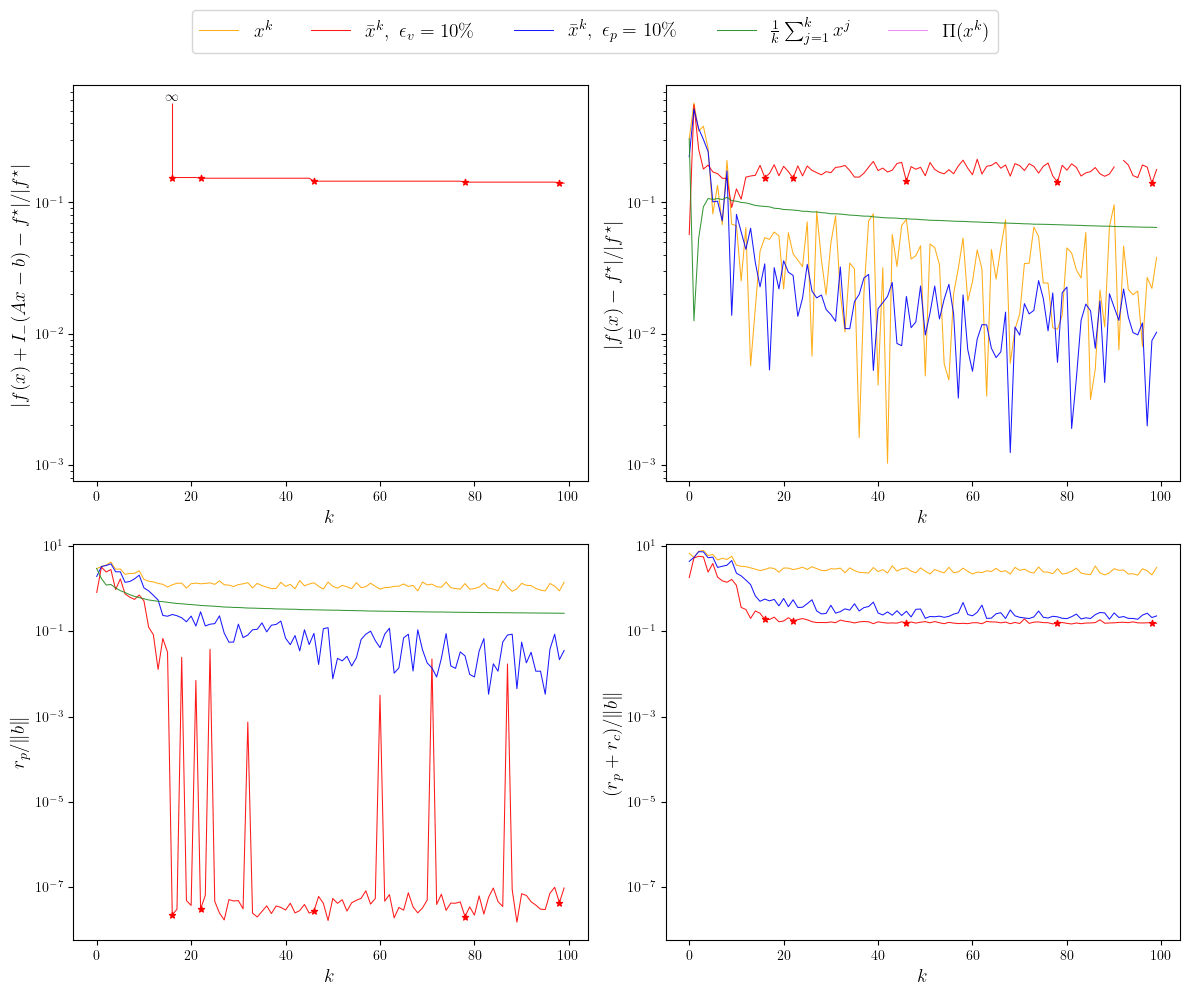

In [8]:
mra.plot_all_methods_metrics_4x(all_results_eps, all_results_noisy_y, true_f, 
                                b_norm, percent, eps_sublevel, filename, T)